# import

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,Dataset

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

from hsic import *

from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn import datasets as clustering

mcolors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'w', 'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen', 'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite', 'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory', 'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray', 'lightslategrey', 'lightsteelblue', 'lightyellow', 'lime', 'limegreen', 'linen', 'magenta', 'maroon', 'mediumaquamarine', 'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise', 'mediumvioletred', 'midnightblue', 'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy', 'oldlace', 'olive', 'olivedrab', 'orange', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip', 'peachpuff', 'peru', 'pink', 'plum', 'powderblue', 'purple', 'rebeccapurple', 'red', 'rosybrown', 'royalblue', 'saddlebrown', 'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue', 'slategray', 'slategrey', 'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'white', 'whitesmoke', 'yellow', 'yellowgreen']
def toColor(label):
    return [mcolors[l] for l in label]

def plot2D(points,color = 'c',title='title', axes = None):
    if points.shape[1] != 2:
        print('need 2 dimension')
        return
    if axes is not None:
        plt.subplot(axes)
    plt.title(title)
    plt.scatter(points[:,0],points[:,1],c=color)

# Deep network

In [2]:
class deepNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(deepNetwork, self).__init__()
        # 3 layer network
        self.fc = nn.Sequential(
            nn.Linear(input_dim,64),
            nn.Sigmoid(),
            nn.Linear(64,128),
            nn.Sigmoid(),
            nn.Linear(128,128),
            nn.Sigmoid(),
            nn.Linear(128,128),
            nn.Sigmoid(),
            nn.Linear(128,output_dim),
        )
    def forward(self, x):
        return self.fc(x)

class kernelEncoder(nn.Module):
    def __init__(self, N, input_dim, output_dim):
        super(kernelEncoder, self).__init__()
        self.net = deepNetwork(input_dim, output_dim)
    def forward(self, x):
        return self.net(x)

class kernelDncoder(nn.Module):
    def __init__(self, N, input_dim, output_dim):
        super(kernelDncoder, self).__init__()
        self.net = deepNetwork(input_dim, output_dim)
    def forward(self, x):
        return self.net(x)

# Data

## dataset

In [3]:
class myDataSet(Dataset):
    def __init__(self,N, _type:str = 'moon'):
        if _type == 'moon':
            self.points, self.true_labels = clustering.make_moons(
                n_samples=N, noise=0.05, random_state=42
            )
            self.label_num = 2
        elif _type == 'circle':
            self.points, self.true_labels = clustering.make_circles(
                n_samples=N, factor=0.5, noise=0.05, random_state=42
            )
            self.label_num = 2
        elif _type == 'blob':
            self.points, self.true_labels = clustering.make_blobs(
                n_samples=N, cluster_std=[1.0, 2.5, 0.5], random_state=42
            )
            self.label_num = 3
        
        self.points = torch.DoubleTensor(self.points, device=device)
        self.labelColor = toColor(self.true_labels)
    
    def groupIndex(self,label):
        ''' given label return points index'''
        return self.true_labels == label

    def group(self, label):
        ''' given label return points'''
        return self.points[self.groupIndex(label)]

    def sample(self, N):
        ''' random sample N '''
        index = np.random.choice(self.__len__(), N, replace=False)
        return self.points[index]

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        return self.points[idx]

# test
if False:
    train_data = myDataSet(1000, 'blob')
    plot2D(train_data.points, title='Points')

# Functions

In [4]:
def f_function(x):
    global encoder, decoder
    return decoder(encoder(x))

def norm(x):
    return (x**2).sum()

def test_network():
    global encoder, train_data
    x = train_data.sample(3)
    with torch.no_grad():
        print(x)
        print(encoder(x))
        print(f_function(x))

## init theta

In [5]:
def init_weight(INIT_EPOCH = 10, ENCODER_LR = 0.01, DECODER_LR = 0.005):
    global encoder, decoder, dataSet

    encoderOptimizer = torch.optim.Adam(encoder.parameters(),lr=ENCODER_LR)
    decoderOptimizer = torch.optim.Adam(decoder.parameters(),lr=DECODER_LR)

    record_loss = []
    # train mode
    encoder.train()
    decoder.train()
    tqdm_ = tqdm(range(INIT_EPOCH))
    for i in tqdm_:
        for points in dataSet:
            encoderOptimizer.zero_grad()
            decoderOptimizer.zero_grad()
            
            loss = norm(points - encoder(points)) + \
                norm(points - f_function(points))
            loss.backward()
            
            encoderOptimizer.step()
            decoderOptimizer.step()
        tqdm_.set_postfix({'loss':loss.item()})

        record_loss.append(loss.item())

    plt.plot(record_loss)

    plt.show()
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(3)
    fig.tight_layout()
    plot2D(to_numpy(encoder(train_data.points)), train_data.labelColor, title='embedding', axes=121)
    plot2D(to_numpy(f_function(train_data.points)), train_data.labelColor, title='f_function', axes=122)
    plt.show()

## Update U

In [6]:
def update_U(points, debug = False):
    global hsic, y_dim

    embedding_k = hsic._kernel_x(encoder(points))
    H = hsic.H
    D = np.diag(to_cpu(embedding_k).mean(1))
    D = torch.tensor(fractional_matrix_power(np.linalg.inv(D), 0.5).real,device=device)
    L =  H @ D @ embedding_k @ D @ H
    # eigenvalue
    _, eigenvectors = np.linalg.eig(to_cpu(L))
    # top C
    U = eigenvectors[:,:y_dim].real

    if debug: # check (U^T) * U = I
        print(U.transpose() @ U)

    return torch.DoubleTensor(U).to(device)

## training loop

In [7]:
def train(EPOCH = 20, ITER = 5, ENCODER_LR = 0.01, DECODER_LR = 0.05, SCHEDULER_STEP = 5, SCHEDULAR_GAMMA = 0.99,
         LAMBDA = 0.01, LAMBDA_STEP=100, LAMBDA_MAX=100, LAMBDA_GAMMA=1):
    global encoder, decoder, dataSet, hsic

    encoderOptimizer = torch.optim.Adam(encoder.parameters(),lr=ENCODER_LR)
    decoderOptimizer = torch.optim.Adam(decoder.parameters(),lr=DECODER_LR)

    encode_LR_Scheduler = torch.optim.lr_scheduler.StepLR(encoderOptimizer, SCHEDULER_STEP, SCHEDULAR_GAMMA)
    decoder_LR_Scheduler = torch.optim.lr_scheduler.StepLR(decoderOptimizer, SCHEDULER_STEP, SCHEDULAR_GAMMA)


    hsic_loss = []
    norm_loss = []
    record_loss = []
    # train mode
    encoder.train()
    decoder.train()
    tqdm_ = tqdm(range(EPOCH))
    for i in tqdm_:
        
        for points in dataSet:
            # update D, U
            hsic.update_D(hsic._kernel_x(points))
            U = update_U(points)
            # D U fixed, update ~theta
            for _ in range(ITER):
                encoderOptimizer.zero_grad()
                decoderOptimizer.zero_grad()

                _hsic = hsic(encoder(points), U)
                _norm = LAMBDA * norm(points - f_function(points))

                loss = _hsic - _norm
                # SGA
                loss = -loss
                loss.backward()
                
                encoderOptimizer.step()
                decoderOptimizer.step()

        decoder_LR_Scheduler.step()
        encode_LR_Scheduler.step()

        hsic_loss.append(_hsic.item())
        norm_loss.append(_norm.item())
        record_loss.append(-(loss.item()))
        tqdm_.set_postfix({'loss': -(loss.item())})

        if i % LAMBDA_STEP == 0 and LAMBDA < LAMBDA_MAX:
            LAMBDA *= LAMBDA_GAMMA
            LAMBDA = min(LAMBDA, LAMBDA_MAX)

    # plot
    fig = plt.figure()
    fig.set_figwidth(16)
    fig.set_figheight(3)
    fig.tight_layout()
    plt.subplot(131)
    plt.title("loss")
    plt.plot(record_loss)
    plt.subplot(132)
    plt.ticklabel_format(useOffset=False)
    plt.title("hsic loss")
    plt.plot(hsic_loss)
    plt.subplot(133)
    plt.title("norm loss")
    plt.plot(norm_loss)
    plt.show()

## plot result

In [8]:
def plot_result(U = None):
    global train_data

    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(8)
    fig.tight_layout()
    plot2D(to_numpy(train_data.points), train_data.labelColor, title='true_label', axes=221)
    if U is not None:
        plot2D(to_numpy(U), title='U(sample)', axes=222)
    plot2D(to_numpy(encoder(train_data.points)), train_data.labelColor, title='embedding', axes=223)
    plot2D(to_numpy(f_function(train_data.points)), train_data.labelColor, title='f_function', axes=224)
    plt.show()

    
def plot_distribution(axis = 0):
    global train_data
    
    fig, axes = plt.subplots(2, train_data.label_num, figsize=(4*train_data.label_num, 8))
    for i in range(train_data.label_num):
        axes[0,i].set_title(f'original label {i} axis-{axis}')
        axes[1,i].set_title(f'embedding label {i} axis-{axis}')

        sns.histplot(to_numpy(train_data.points[train_data.groupIndex(i),axis]),ax=axes[0,i])
        sns.histplot(to_numpy(encoder(train_data.points))[train_data.groupIndex(i),axis],ax=axes[1,i],bins=20)
    plt.show()

## Accuracy

In [9]:
def compare(a, b):
    global train_data
    if len(a) != len(b):
        print('size not match')
        return
    label_num = train_data.label_num
    a = np.eye(label_num)[a]
    b = np.eye(label_num)[b]
    aa = a.T @ a
    bb = b.T @ a
    acc = 0
    for i,o in zip(range(label_num),np.argmax(bb,axis=1)):
        acc += bb[i,o]/aa[i,i]
    acc = (acc / label_num)
    print(acc)
    print(aa)
    print(bb)
    return acc, bb

def apply_kmeans(k, data, title='title'):
    global train_data
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    compare(train_data.true_labels,kmeans.labels_)
    plot2D(to_numpy(train_data.points),color=toColor(kmeans.labels_) , title=title)
    plt.show()
    
def accuracy():
    global encoder, train_data
    apply_kmeans(train_data.label_num, to_numpy(train_data.points), 'oringal')
    apply_kmeans(train_data.label_num, to_numpy(encoder(train_data.points)), 'embedding')

# RUN

## Hyperparameter

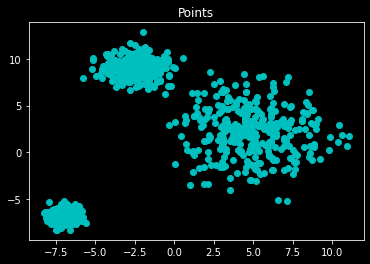

In [10]:
# init loop
INIT_EPOCH = 30

INIT_EBCODER_LR = 0.01
INIT_DECODER_LR = 0.005

# train loop
EPOCH = 20
ITER = 5

ENCODER_LR = 0.01
DECODER_LR = 0.005

SCHEDULER_STEP = 10
SCHEDULER_GAMMA = 0.9

# epoch every LAMBDA_STEP, lambda *= LAMBDA_GAMMA
LAMBDA = 0.005
LAMBDA_STEP = 10
LAMBDA_MAX = 1
LAMBDA_GAMMA = 1.2



# number of sample
N = 1000
BATCH_SIZE = 128
x_dim = 2 # X
y_dim = 2 # U
embedding_dim = x_dim

DEBUG = False

# dataset
train_data = myDataSet(N, 'blob')
plot2D(train_data.points, title='Points')
plt.show()

# global
encoder = kernelEncoder(N, x_dim, embedding_dim).double().to(device)
decoder = kernelDncoder(N, embedding_dim, x_dim).double().to(device)

dataSet = DataLoader(train_data, batch_size=BATCH_SIZE, drop_last=True)
hsic = HSIC(BATCH_SIZE)

sample = train_data.sample(BATCH_SIZE)

if DEBUG:
    print('-----hsic test-----')
    hsic.selfTest()
    print('\n\n-----U test----')
    
    _ = update_U(sample,debug=True)

## Init

100%|██████████| 30/30 [00:01<00:00, 19.20it/s, loss=364]    


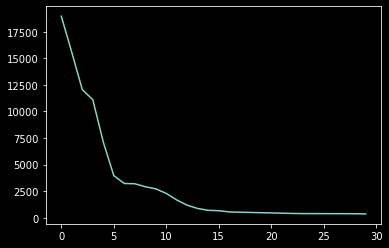

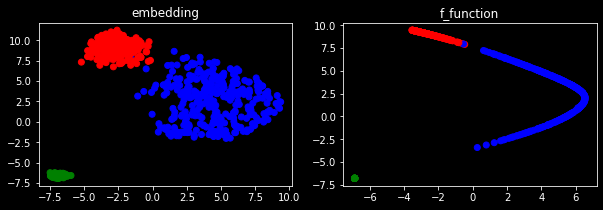

In [11]:
init_weight(INIT_EPOCH, INIT_EBCODER_LR, INIT_DECODER_LR)
if DEBUG:
    print('-----network test----')
    test_network()

## train

100%|██████████| 20/20 [00:06<00:00,  3.07it/s, loss=-1.97]


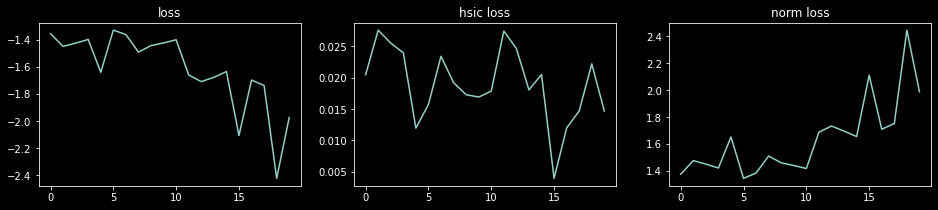

In [15]:
train(EPOCH, ITER, ENCODER_LR, DECODER_LR, SCHEDULER_STEP, SCHEDULER_GAMMA,
        LAMBDA, LAMBDA_STEP, LAMBDA_MAX, LAMBDA_GAMMA)

## plot training result

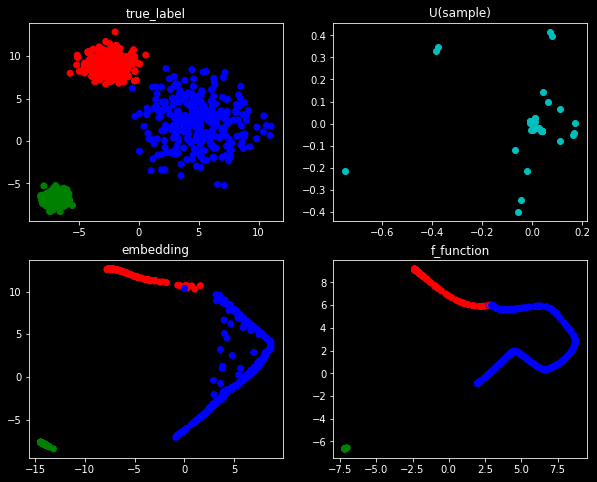

In [16]:
encoder.eval()
decoder.eval()
# plot
plot_result(U = update_U(sample))
if DEBUG:
    plot_distribution(axis = 0)

## k-means eval

0.9919919919919921
[[334.   0.   0.]
 [  0. 333.   0.]
 [  0.   0. 333.]]
[[334.   8.   0.]
 [  0.   0. 333.]
 [  0. 325.   0.]]


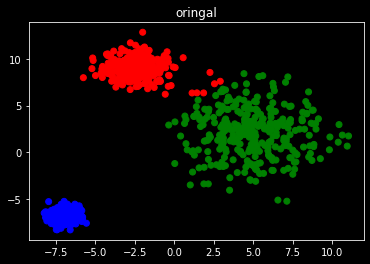

0.9980009950069829
[[334.   0.   0.]
 [  0. 333.   0.]
 [  0.   0. 333.]]
[[  0.   0. 333.]
 [334.   2.   0.]
 [  0. 331.   0.]]


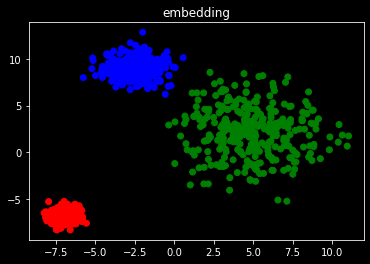

In [17]:
encoder.eval()
decoder.eval()
# eval
accuracy()